<a href="https://colab.research.google.com/github/FernandaSzAdr/KNN_cromossome/blob/master/TesteRede2_Colorida_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [114]:
import os
import cv2
import csv
!pip install imutils
import imutils
from skimage import transform
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import matplotlib.pyplot as plt

In [0]:
train_path = 'drive/My Drive/Base_CNN/Colorido2/Train'
test_path = 'drive/My Drive/Base_CNN/Colorido2/Test'
validation_path = 'drive/My Drive/Base_CNN/Colorido2/Validation'

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Base_CNN/Colorido2/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    image = imutils.resize(image, width=1000)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(1)
            else:
              y_true.append(0)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
            
            # Se é um cromossomo:
            if predicao[0][0] > predicao[0][1]:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict




---



## Implementação



*   Batch size = 32
*   Image size = 120x120



In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [121]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['C', 'NC'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['C', 'NC'], 
                                                 batch_size=bSize)

Found 4369 images belonging to 2 classes.
Found 991 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize



---



### 1 tentativa Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_1'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [158]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 0.7037 - acc: 0.4813 - val_loss: 0.6874 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.68743, saving model to drive/My Drive/Resultado/weights_architecture_1.hdf5
Epoch 2/50
 - 1s - loss: 0.6945 - acc: 0.5312 - val_loss: 0.7089 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.68743
Epoch 3/50
 - 1s - loss: 0.7113 - acc: 0.4438 - val_loss: 0.6938 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.68743
Epoch 4/50
 - 1s - loss: 0.7054 - acc: 0.4875 - val_loss: 0.6960 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.68743
Epoch 5/50
 - 1s - loss: 0.6973 - acc: 0.5062 - val_loss: 0.7077 - val_acc: 0.4375

Epoch 00005: val_loss did not improve from 0.68743
Epoch 6/50
 - 1s - loss: 0.6951 - acc: 0.5250 - val_loss: 0.7163 - val_acc: 0.4375

Epoch 00006: val_loss did not improve from 0.68743
Epoch 7/50
 - 1s - loss: 0.7030 - acc: 0.5874 - val_loss: 0.6826 - val_acc: 0.5938

Epoch 00007: val_loss improved from 

In [0]:
model.load_weights('drive/My Drive/Resultado/weights_architecture_1.hdf5')

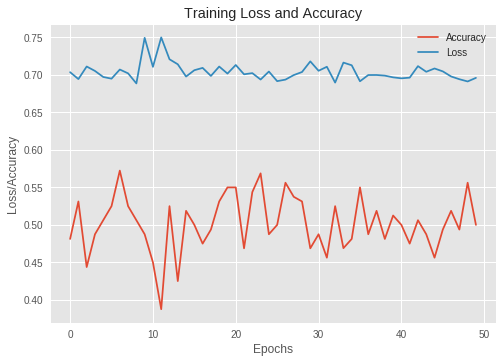

In [160]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [161]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [162]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 80.36%




---



### 2 tentativa  Accuracy: 70.04%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_2'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [167]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.6926 - acc: 0.5500 - val_loss: 0.6956 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 0.69560, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6954 - acc: 0.5000 - val_loss: 0.6927 - val_acc: 0.5938

Epoch 00002: val_loss improved from 0.69560 to 0.69273, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6928 - acc: 0.5375 - val_loss: 0.6920 - val_acc: 0.5625

Epoch 00003: val_loss improved from 0.69273 to 0.69203, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6919 - acc: 0.5938 - val_loss: 0.6930 - val_acc: 0.4688

Epoch 00004: val_loss did not improve from 0.69203
Epoch 5/50
 - 1s - loss: 0.6913 - acc: 0.5812 - val_loss: 0.6908 - val_acc: 0.5938

Epoch 00005: val_loss improved from 0.69203 to 0.69085, saving model to drive/My Drive/Resultado/weights_architecture_2.hdf5
Epoch 6/50
 - 1s - loss: 0.6909 -

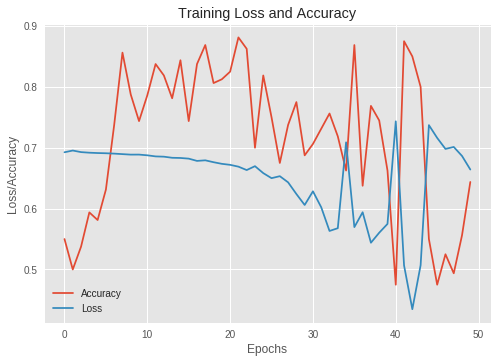

In [168]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [169]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [170]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 70.04%


### 3 tentativa Accuracy: 42.56%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_3'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [175]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 1.1266 - acc: 0.6250 - val_loss: 0.5112 - val_acc: 0.7969

Epoch 00001: val_loss improved from inf to 0.51117, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 0.8316 - acc: 0.7406 - val_loss: 1.1860 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.51117
Epoch 3/50
 - 1s - loss: 0.5275 - acc: 0.8312 - val_loss: 0.8363 - val_acc: 0.7188

Epoch 00003: val_loss did not improve from 0.51117
Epoch 4/50
 - 1s - loss: 0.4668 - acc: 0.8875 - val_loss: 0.5216 - val_acc: 0.8594

Epoch 00004: val_loss did not improve from 0.51117
Epoch 5/50
 - 0s - loss: 0.4510 - acc: 0.8438 - val_loss: 0.6863 - val_acc: 0.7031

Epoch 00005: val_loss did not improve from 0.51117
Epoch 6/50
 - 0s - loss: 0.3686 - acc: 0.8719 - val_loss: 0.3056 - val_acc: 0.8750

Epoch 00006: val_loss improved from 0.51117 to 0.30563, saving model to drive/My Drive/Resultado/weights_architecture_3.hdf5
Epoch 7/50
 - 0s - loss: 0.3319 - acc: 0.8750 

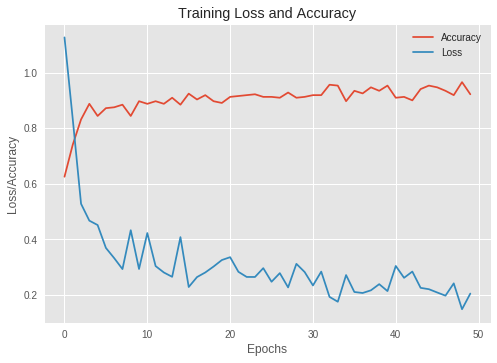

In [176]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [177]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [178]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 42.56%


### 4 tentativa  Accuracy: 67.40%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_4'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [183]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 0.6967 - acc: 0.7188 - val_loss: 0.5998 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.59978, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.3879 - acc: 0.8812 - val_loss: 0.6627 - val_acc: 0.7656

Epoch 00002: val_loss did not improve from 0.59978
Epoch 3/50
 - 1s - loss: 0.2741 - acc: 0.9219 - val_loss: 0.7518 - val_acc: 0.7656

Epoch 00003: val_loss did not improve from 0.59978
Epoch 4/50
 - 1s - loss: 0.2616 - acc: 0.9250 - val_loss: 0.5703 - val_acc: 0.8125

Epoch 00004: val_loss improved from 0.59978 to 0.57033, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 5/50
 - 0s - loss: 0.2480 - acc: 0.9156 - val_loss: 0.4118 - val_acc: 0.8906

Epoch 00005: val_loss improved from 0.57033 to 0.41183, saving model to drive/My Drive/Resultado/weights_architecture_4.hdf5
Epoch 6/50
 - 0s - loss: 0.3293 - acc: 0.8688 - val_loss: 1.5122 - val_acc: 0.6562

Epoch 00006: val_loss d

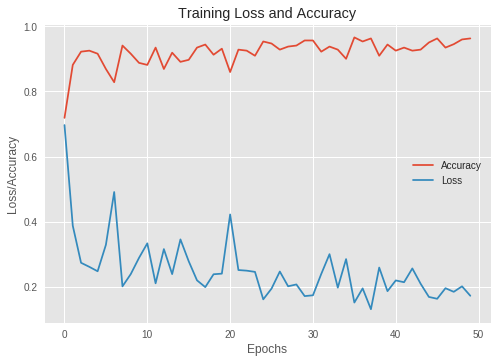

In [184]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [185]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [186]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 67.40%


### 5 tentativa Accuracy: 38.43%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_5'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [191]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 1.3269 - acc: 0.5563 - val_loss: 0.8755 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.87554, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 0.6389 - acc: 0.7313 - val_loss: 0.7639 - val_acc: 0.6719

Epoch 00002: val_loss improved from 0.87554 to 0.76392, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 0.7879 - acc: 0.7031 - val_loss: 0.5979 - val_acc: 0.7344

Epoch 00003: val_loss improved from 0.76392 to 0.59793, saving model to drive/My Drive/Resultado/weights_architecture_5.hdf5
Epoch 4/50
 - 0s - loss: 0.4664 - acc: 0.8438 - val_loss: 0.6260 - val_acc: 0.7344

Epoch 00004: val_loss did not improve from 0.59793
Epoch 5/50
 - 0s - loss: 0.4896 - acc: 0.8312 - val_loss: 0.7854 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.59793
Epoch 6/50
 - 0s - loss: 0.5911 - acc: 0.7844 - val_loss: 0.5027 - val_acc: 0.8750

Epoch 00006: val_loss i

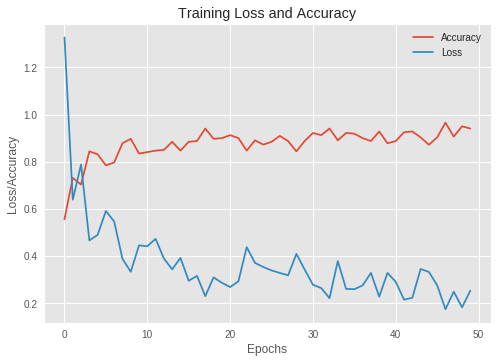

In [192]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [193]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [194]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 38.43%


### 6 tentativa Accuracy: 74.07%

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_6'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [199]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 7s - loss: 0.5166 - acc: 0.7625 - val_loss: 1.9967 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 1.99675, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.3811 - acc: 0.8582 - val_loss: 1.4380 - val_acc: 0.5781

Epoch 00002: val_loss improved from 1.99675 to 1.43801, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.3726 - acc: 0.8688 - val_loss: 1.1871 - val_acc: 0.6562

Epoch 00003: val_loss improved from 1.43801 to 1.18709, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 4/50
 - 0s - loss: 0.3521 - acc: 0.8781 - val_loss: 1.1999 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 1.18709
Epoch 5/50
 - 0s - loss: 0.3344 - acc: 0.8719 - val_loss: 0.5523 - val_acc: 0.7344

Epoch 00005: val_loss improved from 1.18709 to 0.55230, saving model to drive/My Drive/Resultado/weights_architecture_6.hdf5
Epoch 6/50
 - 0s - loss: 0.3945 -

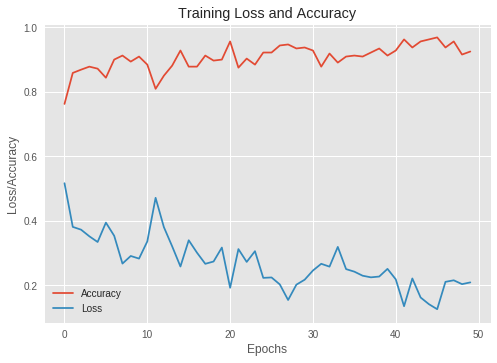

In [200]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [201]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [202]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 74.07%


### 7 tentativa Accuracy: 67.97% 

Modelo adaptado do **Lucas Albertins**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_7'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [207]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 0.4815 - acc: 0.7906 - val_loss: 0.6974 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.69738, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.4348 - acc: 0.8531 - val_loss: 1.4162 - val_acc: 0.6406

Epoch 00002: val_loss did not improve from 0.69738
Epoch 3/50
 - 1s - loss: 0.2679 - acc: 0.9250 - val_loss: 0.3155 - val_acc: 0.8750

Epoch 00003: val_loss improved from 0.69738 to 0.31546, saving model to drive/My Drive/Resultado/weights_architecture_7.hdf5
Epoch 4/50
 - 1s - loss: 0.3308 - acc: 0.8750 - val_loss: 0.7426 - val_acc: 0.7656

Epoch 00004: val_loss did not improve from 0.31546
Epoch 5/50
 - 1s - loss: 0.3004 - acc: 0.9156 - val_loss: 0.3924 - val_acc: 0.8125

Epoch 00005: val_loss did not improve from 0.31546
Epoch 6/50
 - 1s - loss: 0.2901 - acc: 0.8969 - val_loss: 0.7253 - val_acc: 0.6719

Epoch 00006: val_loss did not improve from 0.31546
Epoch 7/50
 - 0s - loss: 0.2366 - acc: 0.9281 

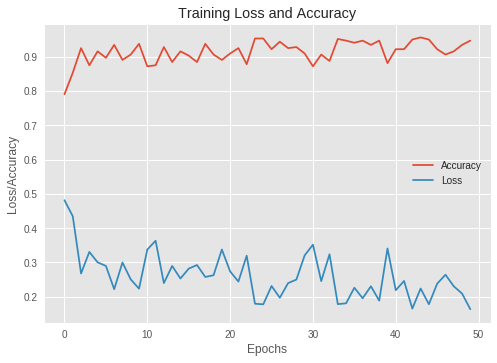

In [208]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [209]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [210]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 67.97%


### 8 tentativa Accuracy: 23.07%

Modelo adaptado do **Lucas Albertins**

*   Função **Adadelta** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_8'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [215]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 8s - loss: 1.0471 - acc: 0.6437 - val_loss: 0.8397 - val_acc: 0.6562

Epoch 00001: val_loss improved from inf to 0.83969, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 0.8319 - acc: 0.7156 - val_loss: 1.5907 - val_acc: 0.5625

Epoch 00002: val_loss did not improve from 0.83969
Epoch 3/50
 - 1s - loss: 0.5192 - acc: 0.8406 - val_loss: 0.3439 - val_acc: 0.8594

Epoch 00003: val_loss improved from 0.83969 to 0.34388, saving model to drive/My Drive/Resultado/weights_architecture_8.hdf5
Epoch 4/50
 - 1s - loss: 0.5768 - acc: 0.8000 - val_loss: 1.0527 - val_acc: 0.5938

Epoch 00004: val_loss did not improve from 0.34388
Epoch 5/50
 - 1s - loss: 0.3279 - acc: 0.9031 - val_loss: 0.4408 - val_acc: 0.7969

Epoch 00005: val_loss did not improve from 0.34388
Epoch 6/50
 - 1s - loss: 0.4277 - acc: 0.8438 - val_loss: 0.4778 - val_acc: 0.7812

Epoch 00006: val_loss did not improve from 0.34388
Epoch 7/50
 - 1s - loss: 0.4166 - acc: 0.8719 

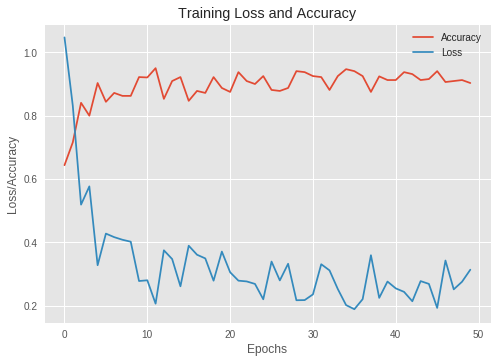

In [216]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [217]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [218]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 23.07%


### 9 tentativa Accuracy: 64.27%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação


In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_9'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [223]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 1.1129 - acc: 0.6219 - val_loss: 1.1445 - val_acc: 0.5938

Epoch 00001: val_loss improved from inf to 1.14455, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 0.8380 - acc: 0.7687 - val_loss: 0.4795 - val_acc: 0.7188

Epoch 00002: val_loss improved from 1.14455 to 0.47952, saving model to drive/My Drive/Resultado/weights_architecture_9.hdf5
Epoch 3/50
 - 1s - loss: 0.5669 - acc: 0.8063 - val_loss: 0.6377 - val_acc: 0.6406

Epoch 00003: val_loss did not improve from 0.47952
Epoch 4/50
 - 0s - loss: 0.6407 - acc: 0.7812 - val_loss: 1.2300 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.47952
Epoch 5/50
 - 0s - loss: 1.0150 - acc: 0.7000 - val_loss: 0.7864 - val_acc: 0.6250

Epoch 00005: val_loss did not improve from 0.47952
Epoch 6/50
 - 0s - loss: 0.4353 - acc: 0.8781 - val_loss: 0.6695 - val_acc: 0.6875

Epoch 00006: val_loss did not improve from 0.47952
Epoch 7/50
 - 0s - loss: 0.4522 - acc: 0.8344 

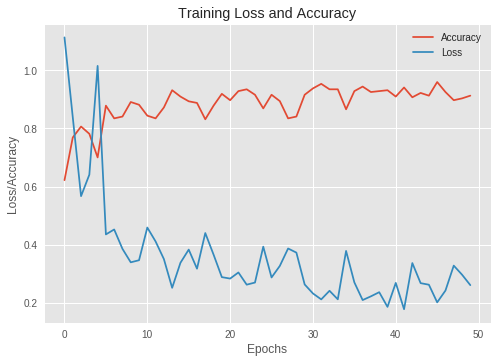

In [224]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [225]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [226]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 64.27%


### 10 tentativa Accuracy: 81.51%

Modelo adaptado do **Lucas Albertins**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_10'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [231]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 1.4200 - acc: 0.5812 - val_loss: 1.0637 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 1.06369, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 0.6042 - acc: 0.7875 - val_loss: 1.5121 - val_acc: 0.5625

Epoch 00002: val_loss did not improve from 1.06369
Epoch 3/50
 - 1s - loss: 0.5335 - acc: 0.8625 - val_loss: 1.8823 - val_acc: 0.5469

Epoch 00003: val_loss did not improve from 1.06369
Epoch 4/50
 - 1s - loss: 0.5167 - acc: 0.8219 - val_loss: 1.0633 - val_acc: 0.6719

Epoch 00004: val_loss improved from 1.06369 to 1.06330, saving model to drive/My Drive/Resultado/weights_architecture_10.hdf5
Epoch 5/50
 - 1s - loss: 0.3487 - acc: 0.8937 - val_loss: 1.3120 - val_acc: 0.6562

Epoch 00005: val_loss did not improve from 1.06330
Epoch 6/50
 - 1s - loss: 0.2567 - acc: 0.9375 - val_loss: 1.3505 - val_acc: 0.6406

Epoch 00006: val_loss did not improve from 1.06330
Epoch 7/50
 - 1s - loss: 0.3488 - acc: 0.896

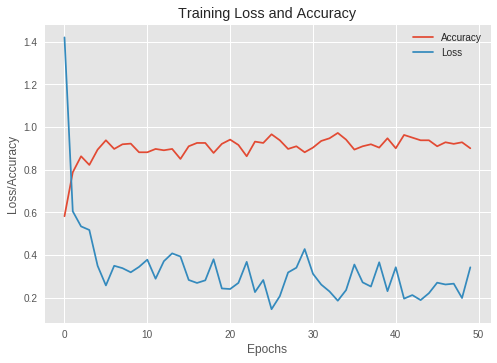

In [232]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [233]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [234]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 81.51%


### 11 tentativa Accuracy: 78.42%

Modelo adaptado do **Lucas Albertins**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_11'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [239]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 9s - loss: 1.1565 - acc: 0.6063 - val_loss: 0.8243 - val_acc: 0.5156

Epoch 00001: val_loss improved from inf to 0.82430, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 0.7155 - acc: 0.7156 - val_loss: 0.6780 - val_acc: 0.6406

Epoch 00002: val_loss improved from 0.82430 to 0.67802, saving model to drive/My Drive/Resultado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 0.6226 - acc: 0.7812 - val_loss: 0.7340 - val_acc: 0.6719

Epoch 00003: val_loss did not improve from 0.67802
Epoch 4/50
 - 1s - loss: 0.4548 - acc: 0.8563 - val_loss: 1.1356 - val_acc: 0.4531

Epoch 00004: val_loss did not improve from 0.67802
Epoch 5/50
 - 1s - loss: 0.4769 - acc: 0.8625 - val_loss: 0.9908 - val_acc: 0.4844

Epoch 00005: val_loss did not improve from 0.67802
Epoch 6/50
 - 1s - loss: 0.4545 - acc: 0.8625 - val_loss: 0.5924 - val_acc: 0.8125

Epoch 00006: val_loss improved from 0.67802 to 0.59241, saving model to drive/My Drive/Resultad

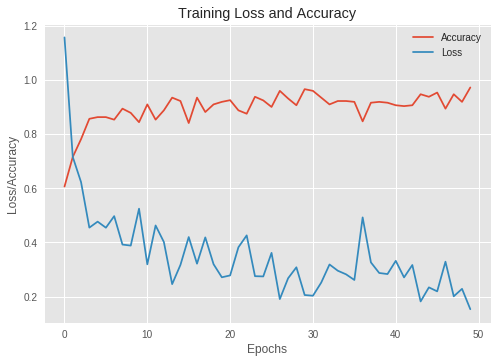

In [240]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [241]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [242]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 78.42%


### 12 tentativa Accuracy: 70.98%

Modelo adaptado do **Lucas Albertins**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
arquiteture = 'architecture_12'

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/weights_' + arquiteture + '.hdf5', verbose=1, save_best_only=True)

In [247]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 10s - loss: 1.5212 - acc: 0.5375 - val_loss: 0.7730 - val_acc: 0.4839

Epoch 00001: val_loss improved from inf to 0.77298, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 0.7406 - acc: 0.7300 - val_loss: 0.6674 - val_acc: 0.5938

Epoch 00002: val_loss improved from 0.77298 to 0.66738, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 0.5735 - acc: 0.7875 - val_loss: 0.6112 - val_acc: 0.8750

Epoch 00003: val_loss improved from 0.66738 to 0.61115, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.5547 - acc: 0.8063 - val_loss: 0.4528 - val_acc: 0.8750

Epoch 00004: val_loss improved from 0.61115 to 0.45281, saving model to drive/My Drive/Resultado/weights_architecture_12.hdf5
Epoch 5/50
 - 1s - loss: 0.7799 - acc: 0.7375 - val_loss: 0.6921 - val_acc: 0.5625

Epoch 00005: val_loss did not improve from 0.45281
Epoch 6/50
 - 1s - loss: 0.4

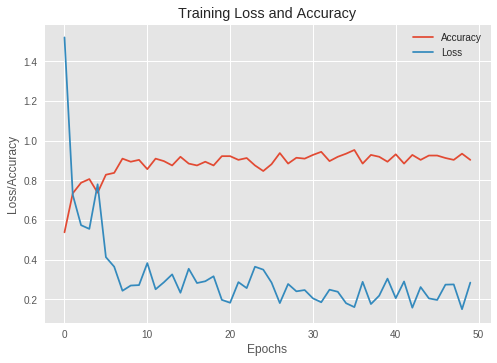

In [248]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/' + arquiteture + '.png', bbox_inches='tight')

In [249]:
y_true, y_predict = ler_images_teste(arquiteture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [250]:
results[arquiteture] = accuracy_score(y_true, y_predict)
print('Test Accuracy: {:.2f}%'.format(100 * results[arquiteture]))

Test Accuracy: 70.98%
